# Multi-product SARIMA analysis (statsmodels fallback)

Requirements: `numpy`, `pandas`, `statsmodels`, `scikit-learn`, `matplotlib`, `seaborn`.

Note: Install packages in your activated virtual environment (recommended) rather than running installs inline in the notebook.

In [1]:
# Install plotting packages in your environment if missing:
# python -m pip install matplotlib seaborn

In [2]:
# # Install statsmodels into the kernel's Python (runs pip in the same interpreter)
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm  # Progress bar for notebook

In [4]:
# Load CSV with proper NaN handling
csv_path = 'consolidated_file_cleaned_v2.csv'
# csv_path = 'sample.csv'
# csv_path = 'consolidated_file_cleaned_v1_trimmed_by_product_ids_0pct.csv'
df = pd.read_csv(csv_path, na_values=['', ' ', 'NaN'])

In [5]:
# Clean column headers: remove special chars, whitespace, and rename
def clean_col(col):
    col = re.sub(r'\(.*?\)', '', col)  # Remove anything in parentheses
    col = re.sub(r'[^a-zA-Z0-9_ ]', '', col)  # Remove non-alphanumeric except underscore and space
    col = col.strip().replace(' ', '_').lower()
    # Only rename sold/month(₱) to sold_monthly (actual revenue)
    if col in ['sold_month', 'sold_monthly', 'soldmonth', 'sold/month', 'soldmonth₱', 'sold_month₱', 'sold/month₱']:
        return 'sold_monthly'
    if col == 'soldmonth₱' or col == 'sold_month₱' or col == 'sold/month₱':
        return 'sold_monthly'
    if col == 'time':
        return 'date'
    return col
df.columns = [clean_col(c) for c in df.columns]
print('Columns after cleaning:', df.columns.tolist())

Columns after cleaning: ['product', 'date', 'avgsku_price', 'soldday', 'revenueday', 'soldm', 'product_sales_rate', 'price', 'sku', 'sold', 'sold_monthly', 'revenuemonth', 'new_ratings', 'ratings', 'ratings_rate', 'likes', 'rating_star', 'new_likes', 'secondlevel_category', 'thirdlevel_category', 'fourthlevel_category', 'fifthlevel_category', 'id', 'toplevel_category', 'seller_from', 'listing_time', 'active_months', 'suitable_for_seasonal_analysis']


No Batch Processing Fitting

In [6]:
# SARIMA analysis loop: train/validate on 2022-2024, test on 2025
from collections import defaultdict
results_dict = {}
predictions_dict = defaultdict(dict)
residuals_list = []

category_col = 'secondlevel_category'
sales_col = 'sold_monthly'
date_col = 'date'

if category_col not in df.columns:
    raise ValueError('Column "secondlevel_category" not found in dataframe.')
if sales_col not in df.columns:
    raise ValueError('Column "sold_monthly" not found in dataframe.')
if date_col not in df.columns:
    raise ValueError('Column "date" not found in dataframe.')

df[date_col] = pd.to_datetime(df[date_col])
category_groups = list(df.groupby(category_col))

for category, group in tqdm(category_groups, desc='Fitting SARIMA models (by secondlevel_category)'):
    sales = group[[date_col, sales_col]].copy()
    sales[sales_col] = pd.to_numeric(sales[sales_col], errors='coerce').fillna(0)
    sales = sales.loc[:, ~sales.columns.duplicated()]
    sales = sales.groupby(date_col).sum()
    all_months = pd.date_range(start=sales.index.min(), end=sales.index.max(), freq='MS')
    sales = sales.reindex(all_months, fill_value=0)
    monthly_sales = sales[sales_col]

    # Split by year
    train_val = monthly_sales[(monthly_sales.index.year >= 2022) & (monthly_sales.index.year <= 2024)]
    test = monthly_sales[monthly_sales.index.year == 2025]

    if len(train_val) < 12 or len(test) < 1:
        continue

    try:
        # Train SARIMA on 2022-2024
        model = SARIMAX(train_val, order=(1,1,1), seasonal_order=(1,1,1,12))
        results = model.fit(disp=False)
        results_dict[category] = results

        # Forecast for 2025
        forecast = results.get_forecast(steps=len(test))
        pred_2025 = forecast.predicted_mean
        predictions_dict[category]['test'] = (test.values, pred_2025.values)

        # Store residuals for all months in train_val and test
        # In-sample residuals
        fitted = results.fittedvalues
        for dt, actual, pred in zip(train_val.index, train_val.values, fitted.values):
            residuals_list.append({
                'secondlevel_category': category,
                'date': dt,
                'actual': actual,
                'predicted': pred,
                'residual': actual - pred
            })
        # Out-of-sample residuals (2025)
        for dt, actual, pred in zip(test.index, test.values, pred_2025.values):
            residuals_list.append({
                'secondlevel_category': category,
                'date': dt,
                'actual': actual,
                'predicted': pred,
                'residual': actual - pred
            })
    except Exception as e:
        continue

Fitting SARIMA models (by secondlevel_category):   0%|          | 0/215 [00:00<?, ?it/s]

c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few ob

### RMSE and MAPE for Validation and Test Sets
This cell computes RMSE and MAPE for each product's validation and test sets using the predictions from the previous cell.

In [7]:
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan

metrics = []
for cat, preds in predictions_dict.items():
    test_true, test_pred = preds.get('test', ([], []))
    metrics.append({
        'secondlevel_category': cat,
        'test_rmse': rmse(test_true, test_pred) if len(test_true) else np.nan,
        'test_mape': mape(test_true, test_pred) if len(test_true) else np.nan,
    })
metrics_df = pd.DataFrame(metrics)
display(metrics_df.head(10))

,secondlevel_category,test_rmse,test_mape
0,Accessories,1.369002e+09,17.935700
1,Accessories Sets & Packages,1.306583e+07,16.076086
2,Additional Accessories,7.811029e+07,14.403443
3,Alcoholic Beverages,1.653449e+07,21.066689
4,Amplifiers & Mixers,1.736397e+07,34.255716
5,Anklets,9.356149e+05,24.503249
6,Art Supplies,4.958097e+07,18.599053
7,Audio & Video Cables & Converters,4.321213e+07,26.251264
8,Automobile Exterior Accessories,6.267060e+07,14.329709
9,Automobile Interior Accessories,2.814338e+08,14.002214


### Confusion Matrix Metrics for Sales Threshold
This cell computes confusion matrix metrics (TP, FP, TN, FN) for each product's test set, using a sales threshold (e.g., >0 means "positive"). Adjust the threshold as needed.

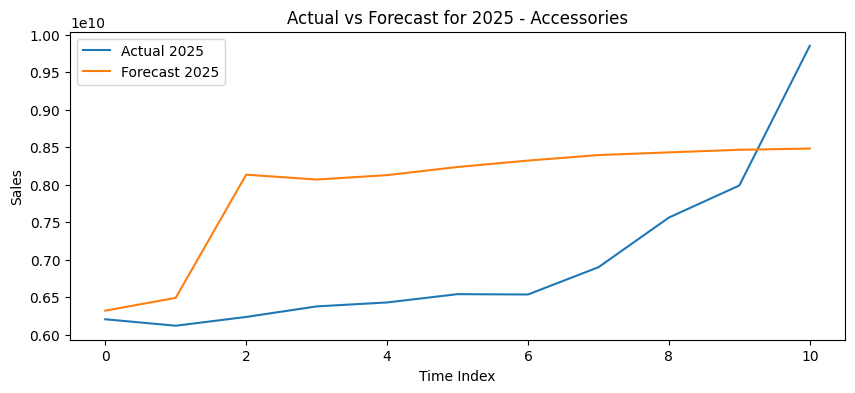

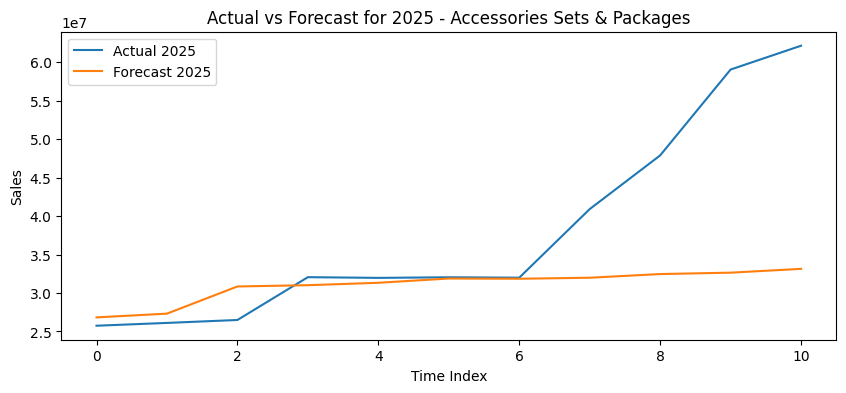

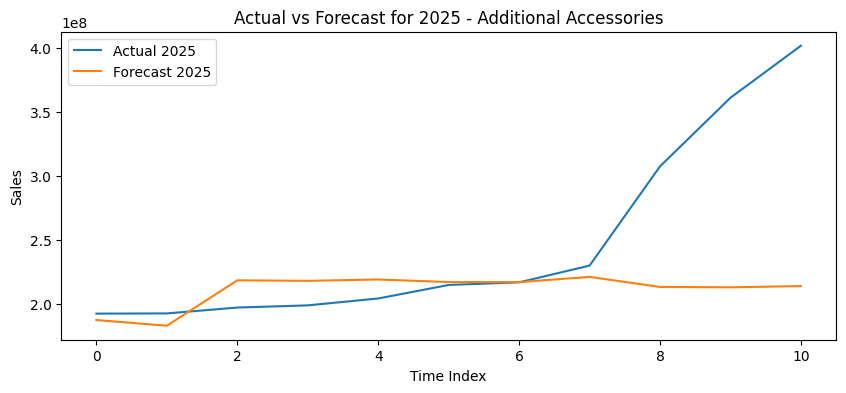

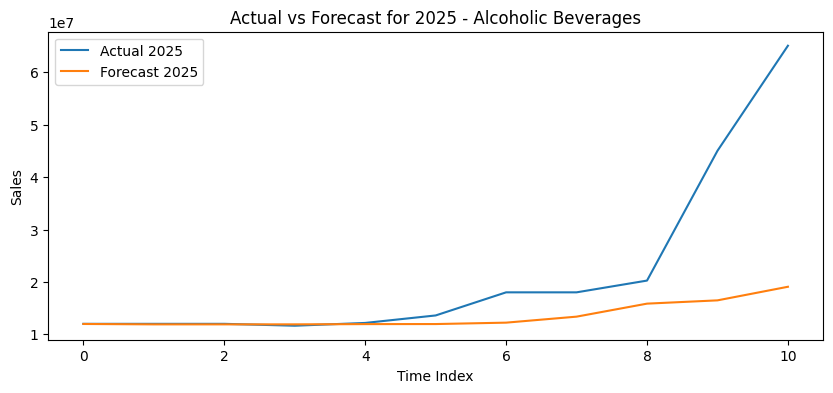

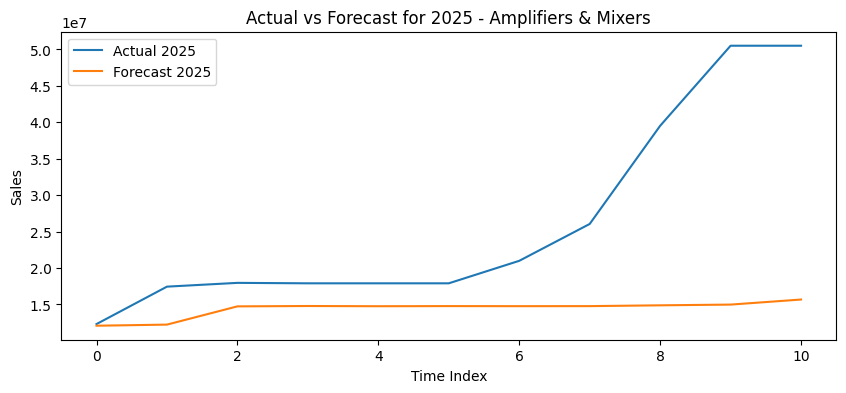

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize actual vs predicted for 2025 for a few categories
num_categories_to_plot = 5
plotted = 0
for cat, preds in predictions_dict.items():
    test_true, test_pred = preds.get('test', ([], []))
    if len(test_true) and len(test_pred):
        plt.figure(figsize=(10, 4))
        plt.plot(test_true, label='Actual 2025')
        plt.plot(test_pred, label='Forecast 2025')
        plt.title(f'Actual vs Forecast for 2025 - {cat}')
        plt.xlabel('Time Index')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()
        plotted += 1
    if plotted >= num_categories_to_plot:
        break

### Summary Plots for Metrics
This cell visualizes the distribution of RMSE, MAPE, and F1 scores across products.

NameError: name 'confusion_df' is not defined

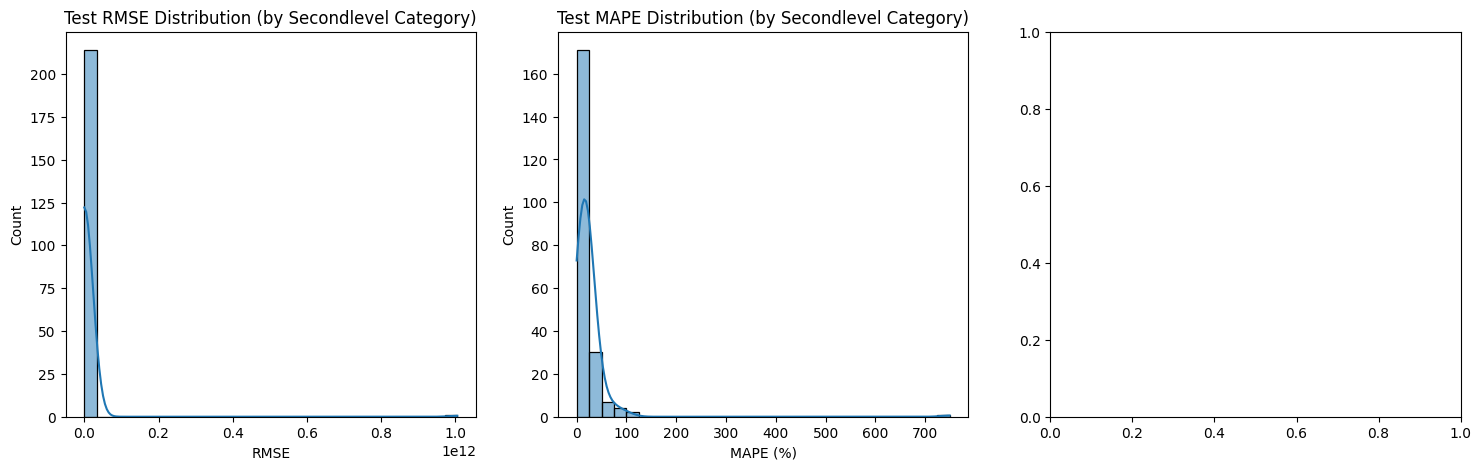

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(metrics_df['test_rmse'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('Test RMSE Distribution (by Secondlevel Category)')
axes[0].set_xlabel('RMSE')

sns.histplot(metrics_df['test_mape'].dropna(), ax=axes[1], kde=True)
axes[1].set_title('Test MAPE Distribution (by Secondlevel Category)')
axes[1].set_xlabel('MAPE (%)')

if 'F1' in confusion_df.columns:
    sns.histplot(confusion_df['F1'].dropna(), ax=axes[2], kde=True)
    axes[2].set_title('Test F1 Score Distribution (by Secondlevel Category)')
    axes[2].set_xlabel('F1 Score')
else:
    axes[2].set_visible(False)

plt.tight_layout()
plt.show()

## Visualize SARIMA Results for a Selected Product

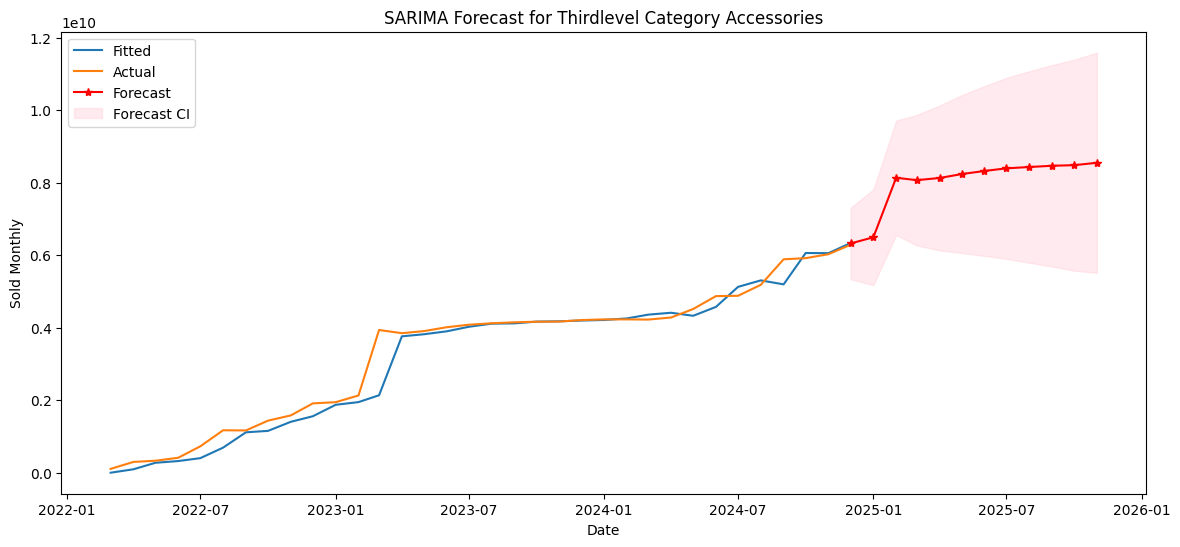

In [ ]:
# Change index to visualize other thirdlevel categories
selected_cat = list(results_dict.keys())[0] if results_dict else None
if selected_cat:
    res = results_dict[selected_cat]
    plt.figure(figsize=(14,6))
    # Plot the fitted values (in-sample prediction)
    plt.plot(res.fittedvalues.index, res.fittedvalues, label='Fitted')
    # Plot the actuals (if available)
    if hasattr(res.model.data, 'endog') and hasattr(res.model.data, 'row_labels'):
        plt.plot(res.model.data.row_labels, res.model.data.endog, label='Actual')
    # Forecast the next 12 months
    forecast = res.get_forecast(steps=12)
    forecast_index = pd.date_range(res.data.dates[-1], periods=12, freq='MS')
    plt.plot(forecast_index, forecast.predicted_mean, 'r*-', label='Forecast')
    conf_int = forecast.conf_int()
    plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='Forecast CI')
    plt.legend()
    plt.title(f'SARIMA Forecast for Thirdlevel Category {selected_cat}')
    plt.ylabel('Sold Monthly')
    plt.xlabel('Date')
    plt.show()
else:
    print('No thirdlevel categories with valid SARIMA results.')

## Summary Table of RMSE and MAPE for All Products

In [ ]:
# Example: Summary table of AIC for all secondlevel categories
import pandas as pd
summary = pd.DataFrame([
    {'secondlevel_category': cat, 'aic': res.aic}
    for cat, res in results_dict.items()
])
summary.sort_values('aic').head(10)  # Show top 10 secondlevel categories by AIC

,secondlevel_category,aic
122,Men Muslim Wear,-402.544137
155,Prayer Attire & Equipment,-402.544137
161,Sandals & Flip Flops,10.000000
61,Drone Accessories,436.667326
108,Lenses,508.119718
97,Investment Precious Metals,545.448199
203,Utilities,547.059609
44,Clutches,549.519329
5,Anklets,555.113681
39,Briefcases,577.867786


In [ ]:
# --- Peak Demand Months and Top-Selling Secondlevel Categories Analysis ---
# Forecast next 12 months for all secondlevel categories and store results
forecast_horizon = 12
category_forecasts = {}  # {category: pd.Series of forecasted sales}
for cat, res in results_dict.items():
    forecast = res.get_forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(res.data.dates[-1], periods=forecast_horizon, freq='MS')
    category_forecasts[cat] = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# 1. Peak demand months per secondlevel category
peak_months_per_category = {}
for cat, forecast in category_forecasts.items():
    # Find the month(s) with the highest forecasted sales
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    peak_months_per_category[cat] = peak_months

peak_months_df = pd.DataFrame([
    {'secondlevel_category': cat, 'peak_months': ', '.join(months)}
    for cat, months in peak_months_per_category.items()
])
print('Peak demand months per secondlevel category:')
display(peak_months_df.head())

# 2. Top-selling secondlevel categories for a given month
input_month = '2025-01'  # Change this to the month you want to analyze (format: YYYY-MM)
top_categories = []
for cat, forecast in category_forecasts.items():
    # Find forecast for the input month
    val = forecast.get(pd.to_datetime(input_month), None)
    if val is not None:
        top_categories.append({'secondlevel_category': cat, 'forecasted_sales': val})
top_categories_df = pd.DataFrame(top_categories)
if not top_categories_df.empty and 'forecasted_sales' in top_categories_df.columns:
    top_categories_df = top_categories_df.sort_values('forecasted_sales', ascending=False)
    print(f'Top-selling secondlevel categories for {input_month}:')
    display(top_categories_df.head(10))  # Show top 10 secondlevel categories for the selected month
else:
    print(f'No forecasted sales available for {input_month}.')

# 3. Input a secondlevel category to see its forecasted peak months and monthly forecast
input_category = 'Audio'  # Change this to the category you want to analyze, e.g., 'Electronics'
if input_category and input_category in category_forecasts:
    forecast = category_forecasts[input_category]
    print(f'Forecast for secondlevel category {input_category}:')
    display(forecast)
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    print(f'Peak demand month(s): {", ".join(peak_months)}')
else:
    print('Secondlevel category not found in forecasts or not specified.')

Peak demand months per secondlevel category:


,secondlevel_category,peak_months
0,Accessories,2025-11
1,Accessories Sets & Packages,2025-11
2,Additional Accessories,2025-07
3,Alcoholic Beverages,2025-11
4,Amplifiers & Mixers,2025-11


Top-selling secondlevel categories for 2025-01:


,secondlevel_category,forecasted_sales
159,Rings,1.924536e+12
29,Beauty Tools,1.024216e+11
127,Mobile Phones,2.532926e+10
192,Tablets,1.488799e+10
187,Sports & Outdoor Recreation Equipments,8.158974e+09
0,Accessories,6.493427e+09
194,Tools & Home Improvement,6.051419e+09
178,Small Household Appliances,4.674593e+09
163,School & Office Equipment,4.329423e+09
110,Lighting,3.686333e+09


Secondlevel category not found in forecasts or not specified.


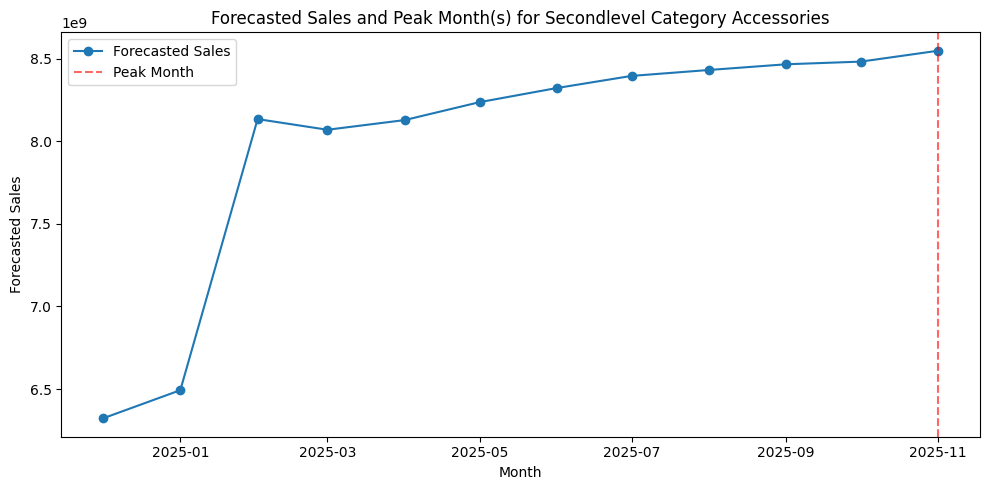

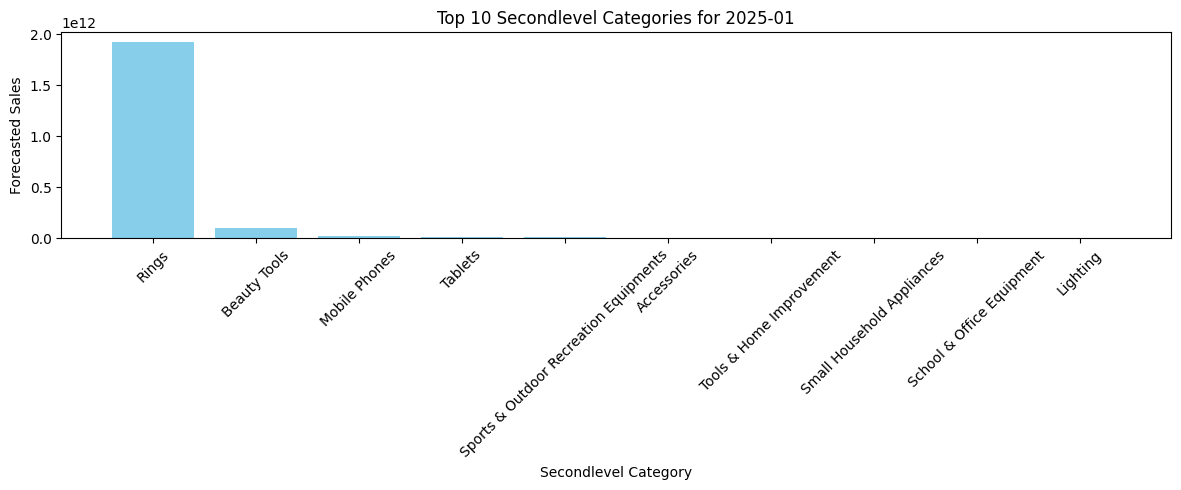

In [ ]:
# --- Visualization for Peak Demand and Top Secondlevel Categories ---
import matplotlib.pyplot as plt

# 1. Visualize peak demand months for a selected secondlevel category
selected_cat = list(category_forecasts.keys())[0] if category_forecasts else None  # Change as needed
if selected_cat:
    forecast = category_forecasts[selected_cat]
    plt.figure(figsize=(10, 5))
    plt.plot(forecast.index, forecast.values, marker='o', label='Forecasted Sales')
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index
    for peak in peak_months:
        plt.axvline(peak, color='red', linestyle='--', alpha=0.6, label='Peak Month' if peak == peak_months[0] else None)
    plt.title(f'Forecasted Sales and Peak Month(s) for Secondlevel Category {selected_cat}')
    plt.xlabel('Month')
    plt.ylabel('Forecasted Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No secondlevel category forecasts available for visualization.')

# 2. Visualize top-selling secondlevel categories for the selected month
try:
    top_categories_df
except NameError:
    print('No top secondlevel categories data available for visualization.')
else:
    if not top_categories_df.empty and 'forecasted_sales' in top_categories_df.columns:
        plt.figure(figsize=(12, 5))
        plt.bar(top_categories_df['secondlevel_category'].astype(str)[:10], top_categories_df['forecasted_sales'][:10], color='skyblue')
        plt.title(f'Top 10 Secondlevel Categories for {input_month}')
        plt.xlabel('Secondlevel Category')
        plt.ylabel('Forecasted Sales')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print('No top secondlevel categories data available for visualization.')

In [ ]:
# --- Export SARIMA models for each thirdlevel category ---
import pickle
import os
import re

def sanitize_filename(name):
    # Remove or replace characters that are invalid in filenames
    return re.sub(r'[^a-zA-Z0-9_-]', '_', str(name))

export_dir = 'sarima_models_exported_by_thirdlevel_category'
os.makedirs(export_dir, exist_ok=True)

for cat, model in results_dict.items():
    safe_cat = sanitize_filename(cat)
    model_path = os.path.join(export_dir, f'sarima_model_{safe_cat}.pkl')
    try:
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
    except Exception as e:
        print(f'Failed to export model for thirdlevel category {cat}: {e}')
print(f'Exported {len(results_dict)} SARIMA models to "{export_dir}".')

Exported 215 SARIMA models to "sarima_models_exported_by_thirdlevel_category".


In [13]:
# --- Identify Uncommon High-Selling Categories Per Month/Season ---
import pandas as pd
from scipy.stats import zscore

residuals_df = pd.DataFrame(residuals_list)

# For each month, find categories with high sales that are uncommon (z-score > 1.5)
# Uncommon: sales are high but category is not among the top historically for that month
uncommon_high_sales = []
for dt, group in residuals_df.groupby('date'):
    # Compute z-score for actual sales in this month
    group = group.copy()
    group['sales_zscore'] = zscore(group['actual']) if len(group) > 1 else 0
    # Threshold for "uncommon high sales"
    threshold = 1.5
    for _, row in group.iterrows():
        if row['sales_zscore'] > threshold:
            uncommon_high_sales.append({
                'date': dt,
                'secondlevel_category': row['secondlevel_category'],
                'actual': row['actual'],
                'predicted': row['predicted'],
                'residual': row['residual'],
                'sales_zscore': row['sales_zscore']
            })
uncommon_df = pd.DataFrame(uncommon_high_sales)
print('Uncommon high-selling categories per month:')
display(uncommon_df.head(20))

Uncommon high-selling categories per month:


,date,secondlevel_category,actual,predicted,residual,sales_zscore
0,2022-03-01,Accessories,105890419.0,0.000000e+00,1.058904e+08,2.369595
1,2022-03-01,Bath & Body Care,204363623.0,0.000000e+00,2.043636e+08,5.087333
2,2022-03-01,Decoration,118291989.0,0.000000e+00,1.182920e+08,2.711863
3,2022-03-01,Food Supplement,93454427.0,0.000000e+00,9.345443e+07,2.026377
4,2022-03-01,Furniture,79928779.0,0.000000e+00,7.992878e+07,1.653086
5,2022-03-01,Kitchen Appliances,149949561.0,0.000000e+00,1.499496e+08,3.585573
6,2022-03-01,Large Household Appliances,86067261.0,0.000000e+00,8.606726e+07,1.822500
7,2022-03-01,Lingerie & Underwear,99644430.0,0.000000e+00,9.964443e+07,2.197213
8,2022-03-01,Makeup,78490344.0,0.000000e+00,7.849034e+07,1.613387
9,2022-03-01,Medical Supplies,230427136.0,0.000000e+00,2.304271e+08,5.806654


In [ ]:
# --- Export residuals to CSV for LSTM modeling ---
import pandas as pd
residuals_df = pd.DataFrame(residuals_list)
residuals_df.to_csv('sarima_residuals_by_secondlevel_category.csv', index=False)
print('Exported SARIMA residuals to sarima_residuals_by_secondlevel_category.csv')